# Cluster analysis

The aim is to find some insights about data in the space of diagnostic variables, excluding the *stage* and *tumor extension* (target variables).

# Methodology

- Filter original dataframe, keeping the patients with all reported tnm categories, stage and tumor extension.
- Standardize values for TNM and stage variables.
    - T: {T0, T1, T2, T3, T4}
    - N: {N0, N1, N2, N3}
    - M: {M0, M1}
    - stages: {0, I, II, III, IV}
- Select features: age, gender, CT, CN, CM, PT, PN, PM
- Map categorical variables to values using OrdinalEncoder
- Normalize data matrix (zero mean and unit variance for each feature)
- Fit and transform using KMeans.
- Reduce dimensionality for visualization using PCA.
- Characterize samples in obtained clusters. For each cluster, compute histograms by subcategory, stage and tumor extension.

# Results

- Clusters show a relation with stages:
    - Clusters 1 and 3 are made up of patients in early stages of cancer (0, I, II).
    - Cluster 0 contains patients in intermediate stages of cancer (II, III).
    - Cluster 2 contains patients in advanced stages of cancer (III, IV).
- First principal component seems to be related with stages of cancer.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
from falp_preprocessing import Standardizer

In [3]:
def get_clusters_histograms(data_with_cluster, column):
    histograms = {}
    for label in data_with_cluster['CLUSTER'].unique():
        points = []
        for category in data_with_cluster[column].unique():
            points.append((
                category,
                data_with_cluster.loc[
                    (data_with_cluster['CLUSTER'] == label) &
                    (data_with_cluster[column] == category)
                ].shape[0]
            ))
        points.sort(key=lambda x: x[0])
        categories, counts = zip(*points)
        histograms[label] = {
            'categories': categories,
            'counts': counts
        }
    return histograms

In [4]:
# User defined parameters
n_clusters = 4

In [5]:
data = pd.read_csv(os.path.join('..', 'RegistroTumoresFALP.csv'))
patients = data.drop_duplicates("ID_CASO")
with_all_diagnoses = patients.loc[
    ~patients["CT"].isna() &
    ~patients["CN"].isna() &
    ~patients["CM"].isna() &
    ~patients["PT"].isna() &
    ~patients["PN"].isna() &
    ~patients["PM"].isna() &
    ~patients["ESTADIO"].isna() &
    ~patients["EXTENSION_DIAGNOSTICO"].isna()
].copy()

In [6]:
stdr = Standardizer()
standardized = stdr.transform(with_all_diagnoses)

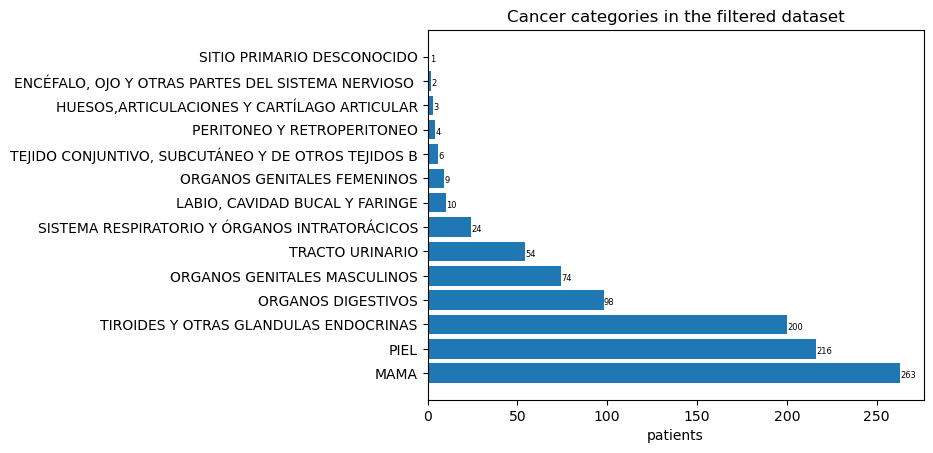

In [7]:
cat_distribution = {}
for category in standardized["CATEGORIA"].unique():
    cat_distribution.update({
        category: standardized.loc[standardized["CATEGORIA"] == category].shape[0]
    })
cat_distribution = dict(sorted(cat_distribution.items(), key=lambda x: x[1], reverse=True))
short_keys = [key[:50] for key in cat_distribution.keys()]
_, ax = plt.subplots()
ax.barh(short_keys, list(cat_distribution.values()))
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize = 6)
ax.set_xlabel('patients')
ax.set_title("Cancer categories in the filtered dataset")
plt.show()

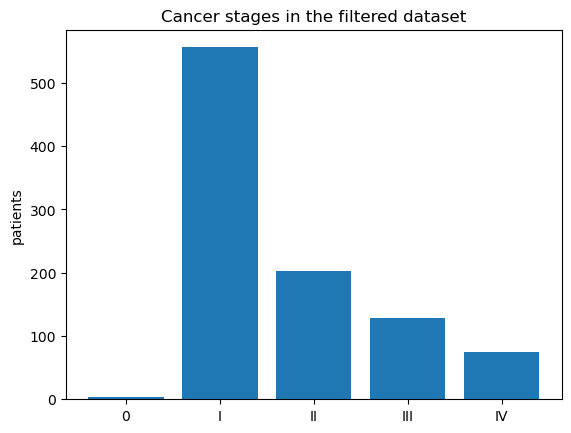

In [8]:
categories, counts = zip(*sorted(
    standardized['ESTADIO'].value_counts().to_dict().items(),
    key=lambda x: x[0]
))
_, ax = plt.subplots()
ax.bar(categories, counts)
ax.set_ylabel('patients')
ax.set_title('Cancer stages in the filtered dataset')
plt.show()

In [9]:
features = [
    'EDAD', 'CATEGORIA', 'SUBCATEGORIA', 'SEXO',
    'CT', 'CN', 'CM', 'PT', 'PN', 'PM'
]
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(standardized[features])

In [10]:
scaler = StandardScaler().fit(X_encoded)
X_normalized = scaler.transform(X_encoded)
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=1).fit(X_normalized)
clusters = {label: [] for label in np.unique(kmeans.labels_)}
for index, label in zip(standardized.index.values, kmeans.labels_):
    clusters[label].append(standardized['ESTADIO'][index])
for label, cluster in sorted(clusters.items(), key=lambda x: x[0]):
    print(f'cluster {label} \n', cluster, '\n')

cluster 0 
 ['II', 'II', 'II', 'II', 'II', 'I', 'II', 'II', 'I', 'II', 'II', 'I', 'I', 'II', 'III', 'III', 'IV', 'III', 'III', 'II', 'I', 'II', 'I', 'I', 'II', 'I', 'III', 'I', 'II', 'I', 'II', 'II', 'II', 'II', 'III', 'II', 'II', 'II', 'II', 'I', 'III', 'I', 'I', 'II', 'II', 'II', 'III', 'IV', 'III', 'III', 'II', 'I', 'III', 'II', 'III', 'IV', 'IV', 'IV', 'IV', 'III', 'II', 'II', 'IV', 'I', 'IV', 'III', 'III', 'II', 'II', 'III', 'II', 'III', 'III', 'III', 'IV', 'IV', 'III', 'III', 'II', 'IV', 'II', 'III', 'III', 'III', 'III', 'III', 'II', 'I', 'II', 'I', 'II', 'III', 'III', 'I', 'III', 'III', 'I', 'I', 'II', 'III', 'III', 'II', 'IV', 'II', 'III', 'II', 'II', 'II', 'III', 'II', 'III', 'III', 'I', 'III', 'III', 'II', 'IV', 'II', 'II', 'II', 'III', 'III', 'III', 'II', 'III', 'IV', 'II', 'III', 'III', 'I', 'II', 'III', 'III', 'II', 'III', 'II', 'IV', 'II', 'II', 'III', 'II', 'II', 'I', 'II', 'III', 'III', 'IV', 'II', 'III', 'III', 'II', 'I', 'II', 'III', 'II', 'III', 'III', 'IV', 'II', 'I

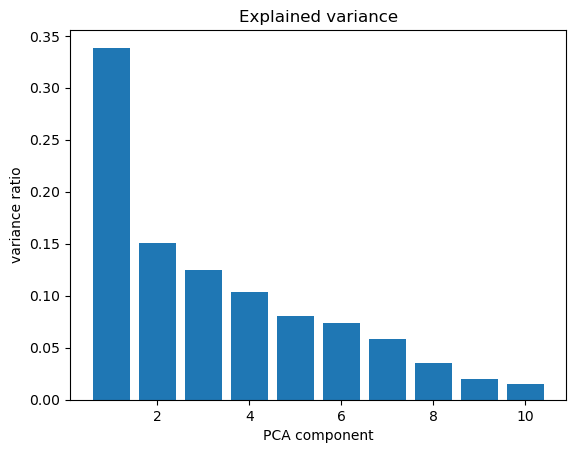

In [11]:
pca = PCA()
pca.fit(X_normalized)
_, ax = plt.subplots()
ax.bar(range(1, pca.n_components_+1), pca.explained_variance_ratio_)
ax.set_xlabel('PCA component')
ax.set_ylabel('variance ratio')
ax.set_title('Explained variance')
plt.show()

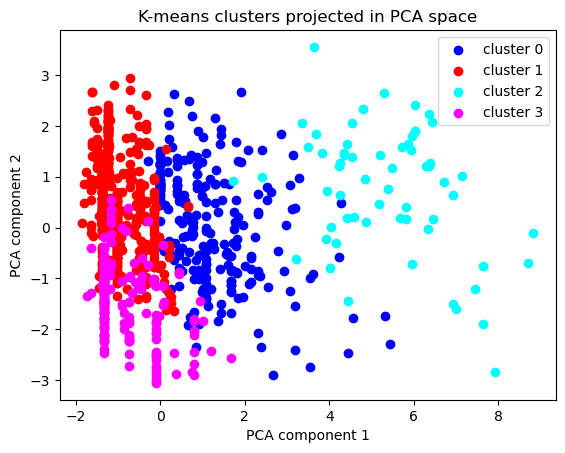

In [12]:
base_colors = ['blue', 'red', 'cyan', 'magenta', 'green']
unique_labels = np.unique(kmeans.labels_)
colors_mapping = {
    unique_labels[i]: base_colors[i]
    for i in unique_labels
}
clustered_samples_indices = {
    unique_labels[i]: []
    for i in unique_labels
}
for idx, label in enumerate(kmeans.labels_):
    clustered_samples_indices[label].append(idx)
reduction_pca = PCA(n_components=2)
X_reduced = reduction_pca.fit_transform(X_normalized)
_, ax = plt.subplots()
for label, color in colors_mapping.items():
    ax.scatter(
        X_reduced[clustered_samples_indices[label],0],
        X_reduced[clustered_samples_indices[label],1],
        c=color,
        label=f'cluster {label}'
    )
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
ax.set_title('K-means clusters projected in PCA space')
ax.legend()
plt.show()

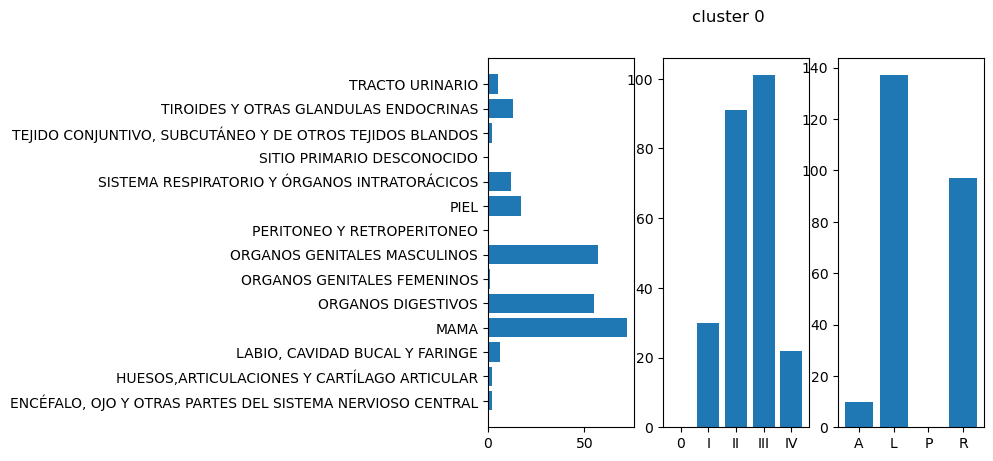

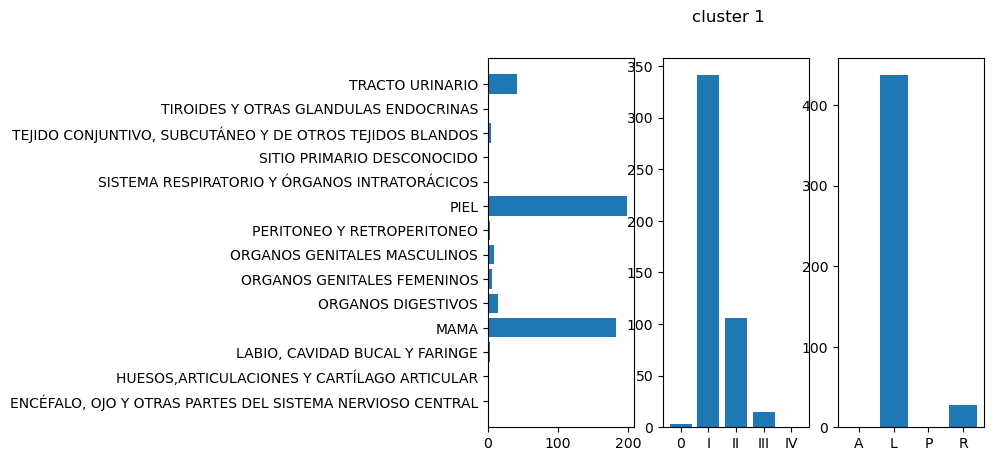

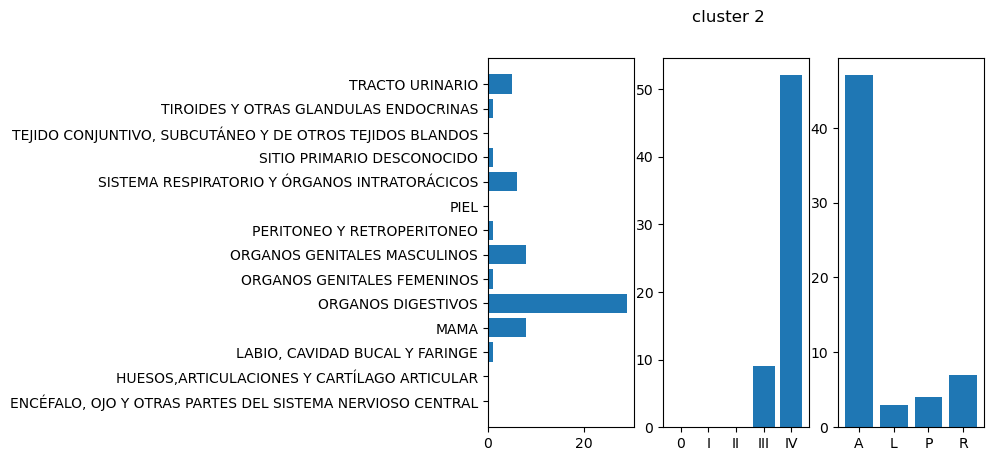

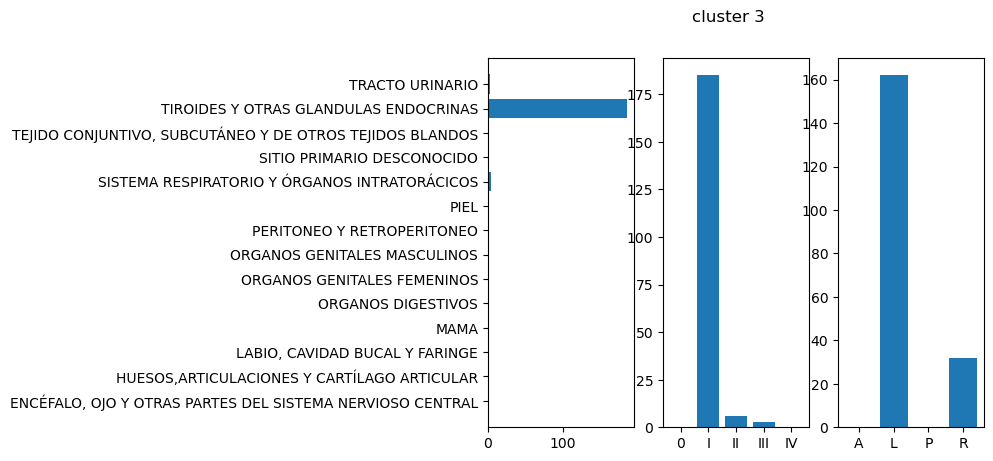

In [13]:
standardized_with_cluster = standardized.copy()
standardized_with_cluster["CLUSTER"] = kmeans.labels_
stage_histograms = get_clusters_histograms(standardized_with_cluster, 'ESTADIO')
extension_histograms = get_clusters_histograms(standardized_with_cluster, 'EXTENSION_DIAGNOSTICO')
category_histograms = get_clusters_histograms(standardized_with_cluster, 'CATEGORIA')
for cluster in sorted(standardized_with_cluster['CLUSTER'].unique()):
    _, ax = plt.subplots(nrows=1, ncols=3)
    ax[0].barh(category_histograms[cluster]['categories'], category_histograms[cluster]['counts'])
    ax[1].bar(stage_histograms[cluster]['categories'], stage_histograms[cluster]['counts'])
    shortened = [extension[0] for extension in extension_histograms[cluster]['categories']] 
    ax[2].bar(shortened, extension_histograms[cluster]['counts'])
    plt.suptitle(f'cluster {cluster}')
    plt.show()